In [1]:
import os
import tempfile

# import destvi_utils
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.model import CondSCVI, DestVI

/home/pxy/miniconda3/envs/destvi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.3


In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = './data/'

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

加载已经预处理好的数据集

In [4]:
st_adata_path = os.path.join(save_dir, "st_lymph_node_preprocessed.h5ad")

st_adata = sc.read(
    st_adata_path,
    backup_url="https://figshare.com/ndownloader/files/52947032",
)
st_adata

AnnData object with n_obs × n_vars = 1092 × 1888
    obs: 'in_tissue', 'array_row', 'array_col', 'batch', 'LN', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'lymph_node'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'LN_colors', 'log1p'
    obsm: 'X_pca', 'X_umap', 'location', 'modules', 'spatial'
    layers: 'counts'

In [5]:
sc_adata_path = os.path.join(save_dir, "sc_lymph_node_preprocessed.h5ad")

sc_adata = sc.read(
    sc_adata_path,
    backup_url="https://figshare.com/ndownloader/files/52947086",
)
sc_adata

AnnData object with n_obs × n_vars = 14989 × 1888
    obs: 'n_genes', 'cell_types', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'pred_cell_types', 'doublet_scores', 'doublet_predictions', 'MS', 'louvain_r0.5', 'louvain_r0.7', 'louvain_r1.0', 'leiden_r0.5', 'leiden_r0.7', 'leiden_r1.0', 'DC_A', 'DC_B', 'mono_1', 'mono_2', 'louvain_sub_0.1', 'louvain_sub_0.2', 'louvain_sub_0.3', 'louvain_sub', 'louvain_sub_1', 'louvain_sub_2', 'louvain_sub_3', 'SCANVI_pred_cell_types', 'SCVI_pred_cell_types', 'broad_cell_types'
    var: 'gene_ids-0', 'genome-0', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'n_counts', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'batch_colors', 'hvg', 'leiden', 'leiden_r1.0_colors', 'log1p', 'louvain', 'louvain_r0.5_colors', 'louvain_r0.7_colors', 'louvain_r1.0_colors', 'louvain_sub_0.2_colors', 'louvain_sub_0.3_colors', 'louvain_sub_1_colo

可视化单细胞数据中的细胞类型

### 以下是DestVI在模拟数据集上尝试

In [1]:
import os
import tempfile

# import destvi_utils
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.model import CondSCVI, DestVI

/home/pxy/miniconda3/envs/destvi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sc_adata = sc.read_h5ad('../data/simulation_Mouse_Kidney_MERFISH/MERFISH_kidney_object.h5ad')
sc_adata

AnnData object with n_obs × n_vars = 126547 × 307
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount', 'average_DAPI_score', 'area', 'n_counts', 'leiden', 'free_annotation'
    uns: 'free_annotation_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [3]:
st_adata = sc.read_h5ad('../data/simulation_Mouse_Kidney_MERFISH/MK_simulated_ST.h5ad')
st_adata

AnnData object with n_obs × n_vars = 1520 × 307
    obs: 'spot_id', 'n_cells'
    uns: 'cell_types'
    obsm: 'spatial', 'true_proportion'

In [ ]:
# sc_adata.var['genome-0'].unique

<bound method Series.unique of 1300017J02Rik    mm10
1500009L16Rik    mm10
1600010M07Rik    mm10
1700025G04Rik    mm10
1700097N02Rik    mm10
                 ... 
Zfp36            mm10
Zfp366           mm10
Zfp516           mm10
Zmynd15          mm10
Zyx              mm10
Name: genome-0, Length: 1888, dtype: category
Categories (1, object): ['mm10']>

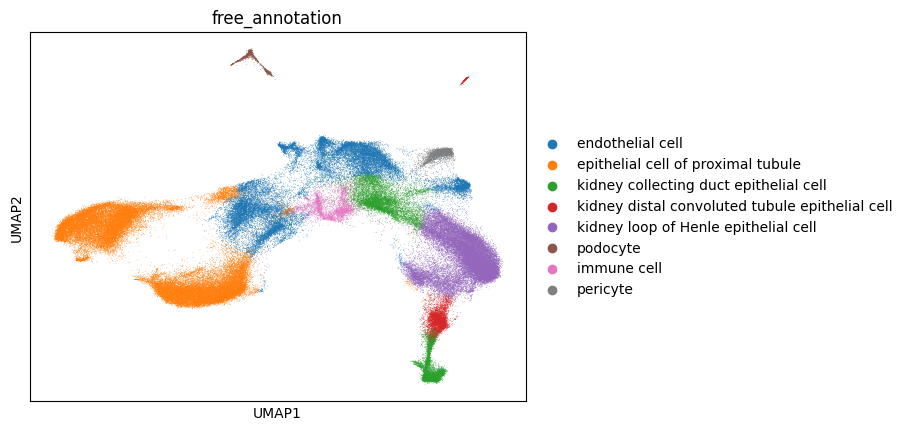

In [4]:
sc.pl.umap(sc_adata, color="free_annotation")

In [5]:
# 计算单细胞基因个数？
G = len(sc_adata.var_names)

KeyError: 'Could not find key area in .var_names or .obs.columns.'

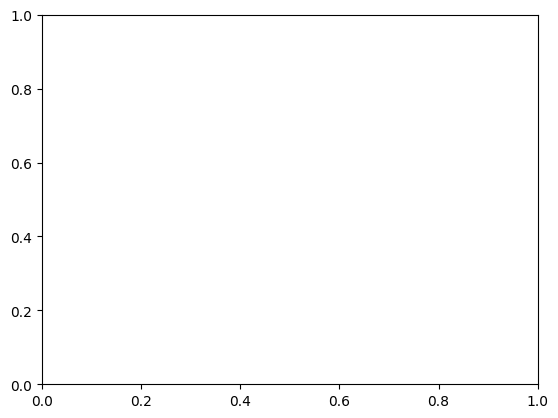

In [ ]:
# # 用空间坐标展示ST数据，根据颜色区分淋巴结分组
# sc.pl.embedding(st_adata, basis="spatial", color="lymph_node", s=80)

### 拟合单细胞潜在变量模型scLVM来学习细胞状态特异性基因表达模式

In [8]:
# 将单细胞数据中的原始计数数据layers['counts']、细胞类型标签broad_cell_types创建anndataManager
# manager 绑定到模型类，后续训练和推断时自动调用。
CondSCVI.setup_anndata(sc_adata, layer="counts", labels_key="free_annotation")

第一步，用细胞类型条件变分自编码器（VAE）scLVM对数据进行嵌入。

传入包含原始计数的层（layer）和细胞类型标签（labels key）。

训练这个模型时，不会根据细胞类型的丰度对损失函数进行加权。

In [9]:
sc_model = CondSCVI(sc_adata, weight_obs=False)
sc_model.view_anndata_setup()

Anndata setup with scvi-tools version 1.3.3.

Setup via `CondSCVI.setup_anndata` with arguments:

{'labels_key': 'free_annotation', 'layer': 'counts', 'batch_key': None}

     Summary Statistics      
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Summary Stat Key ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│     n_batch      │   1    │
│     n_cells      │ 126547 │
│     n_labels     │   8    │
│      n_vars      │  307   │
└──────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                                         labels State Registry                                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃                   Categories                    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['free_annotation'] │                endothelial cell                 │          0          │
│                              │       epithelial cell of proximal tubule        │          1          │
│                              │     kidney collecting duct epithelial cell      │          2          │
│                              │ kidney distal convoluted tubule epithelial cell │          3          │
│                              │      kidney loop of Henle epithelial cell       │          4          │
│                              │                    podocyte                     │          5          │
│                              │                   immune cell                   │          6          │
│                              │                    pericyte                     │          7          │
└──────────────────────────────┴─────────────────────────────────────────────────┴─────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

In [10]:
sc_model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pxy/miniconda3/envs/destvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 300/300: 100%|██████████| 300/300 [57:15<00:00, 11.92s/it, v_num=1, train_loss_step=158, train_loss_epoch=149]  

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [57:15<00:00, 11.45s/it, v_num=1, train_loss_step=158, train_loss_epoch=149]


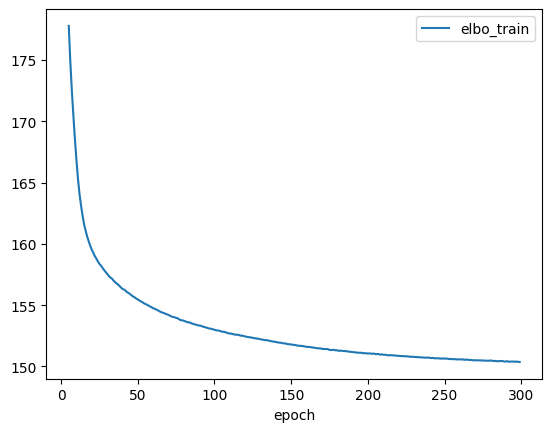

In [11]:
sc_model.history["elbo_train"].iloc[5:].plot()
plt.show()

使用stLVM进行反卷积

In [14]:
DestVI.setup_anndata(st_adata)

/home/pxy/home/pxy/scvi-tools-DestVI/src/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [15]:
st_model = DestVI.from_rna_model(st_adata, sc_model)
st_model.view_anndata_setup()

Anndata setup with scvi-tools version 1.3.3.

Setup via `DestVI.setup_anndata` with arguments:

{'layer': None}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 1520  │
│      n_vars      │  307  │
└──────────────────┴───────┘

             Data Registry              
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃  scvi-tools Location  ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │        adata.X        │
│    ind_x     │ adata.obs['_indices'] │
└──────────────┴───────────────────────┘

In [16]:
st_model.train(max_epochs=1500)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pxy/miniconda3/envs/destvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 1500/1500: 100%|██████████| 1500/1500 [04:28<00:00,  5.59it/s, v_num=1, train_loss_step=2.31e+6, train_loss_epoch=2.26e+6]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1500/1500: 100%|██████████| 1500/1500 [04:28<00:00,  5.59it/s, v_num=1, train_loss_step=2.31e+6, train_loss_epoch=2.26e+6]


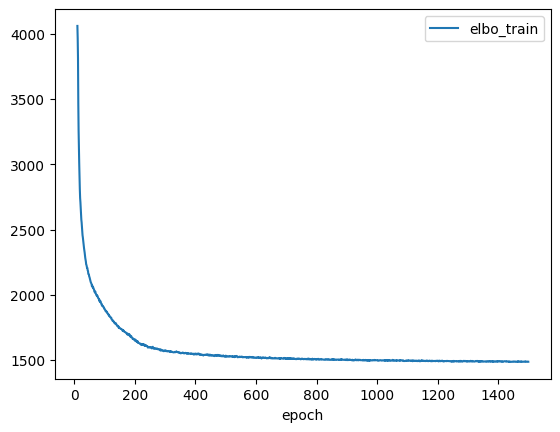

In [17]:
st_model.history["elbo_train"].iloc[10:].plot()
plt.show()

求CTP Cell type proportions细胞类型比例

提取计算出的细胞类型比例并将它们显示在空间嵌入中。

这些值是通过对 stLVM 模型中的 spot-level 参数进行归一化直接计算的。

In [18]:
st_adata.obsm["proportions"] = st_model.get_proportions()

In [20]:
proportions_df = st_adata.obsm["proportions"]
proportions_df.to_csv("destvi_predicted_proportions.csv", index=True)

In [19]:
st_adata.obsm["proportions"].head(5)

,endothelial cell,epithelial cell of proximal tubule,kidney collecting duct epithelial cell,kidney distal convoluted tubule epithelial cell,kidney loop of Henle epithelial cell,podocyte,immune cell,pericyte
0,0.031094,0.954188,0.000393,0.000897,0.011294,0.000174,0.001955,0.000004
1,0.058188,0.798584,0.005520,0.008470,0.045835,0.037194,0.046159,0.000050
2,0.086443,0.810997,0.004056,0.007109,0.040874,0.043704,0.006569,0.000247
3,0.137569,0.496217,0.015770,0.049690,0.135840,0.121623,0.040769,0.002523
4,0.230908,0.528207,0.008957,0.015988,0.020795,0.150539,0.043699,0.000906


In [22]:
ct_list = ["B cells", "CD8 T cells", "Monocytes"]
for ct in ct_list:
    data = st_adata.obsm["proportions"][ct].values
    st_adata.obs[ct] = np.clip(data, 0, np.quantile(data, 0.99))

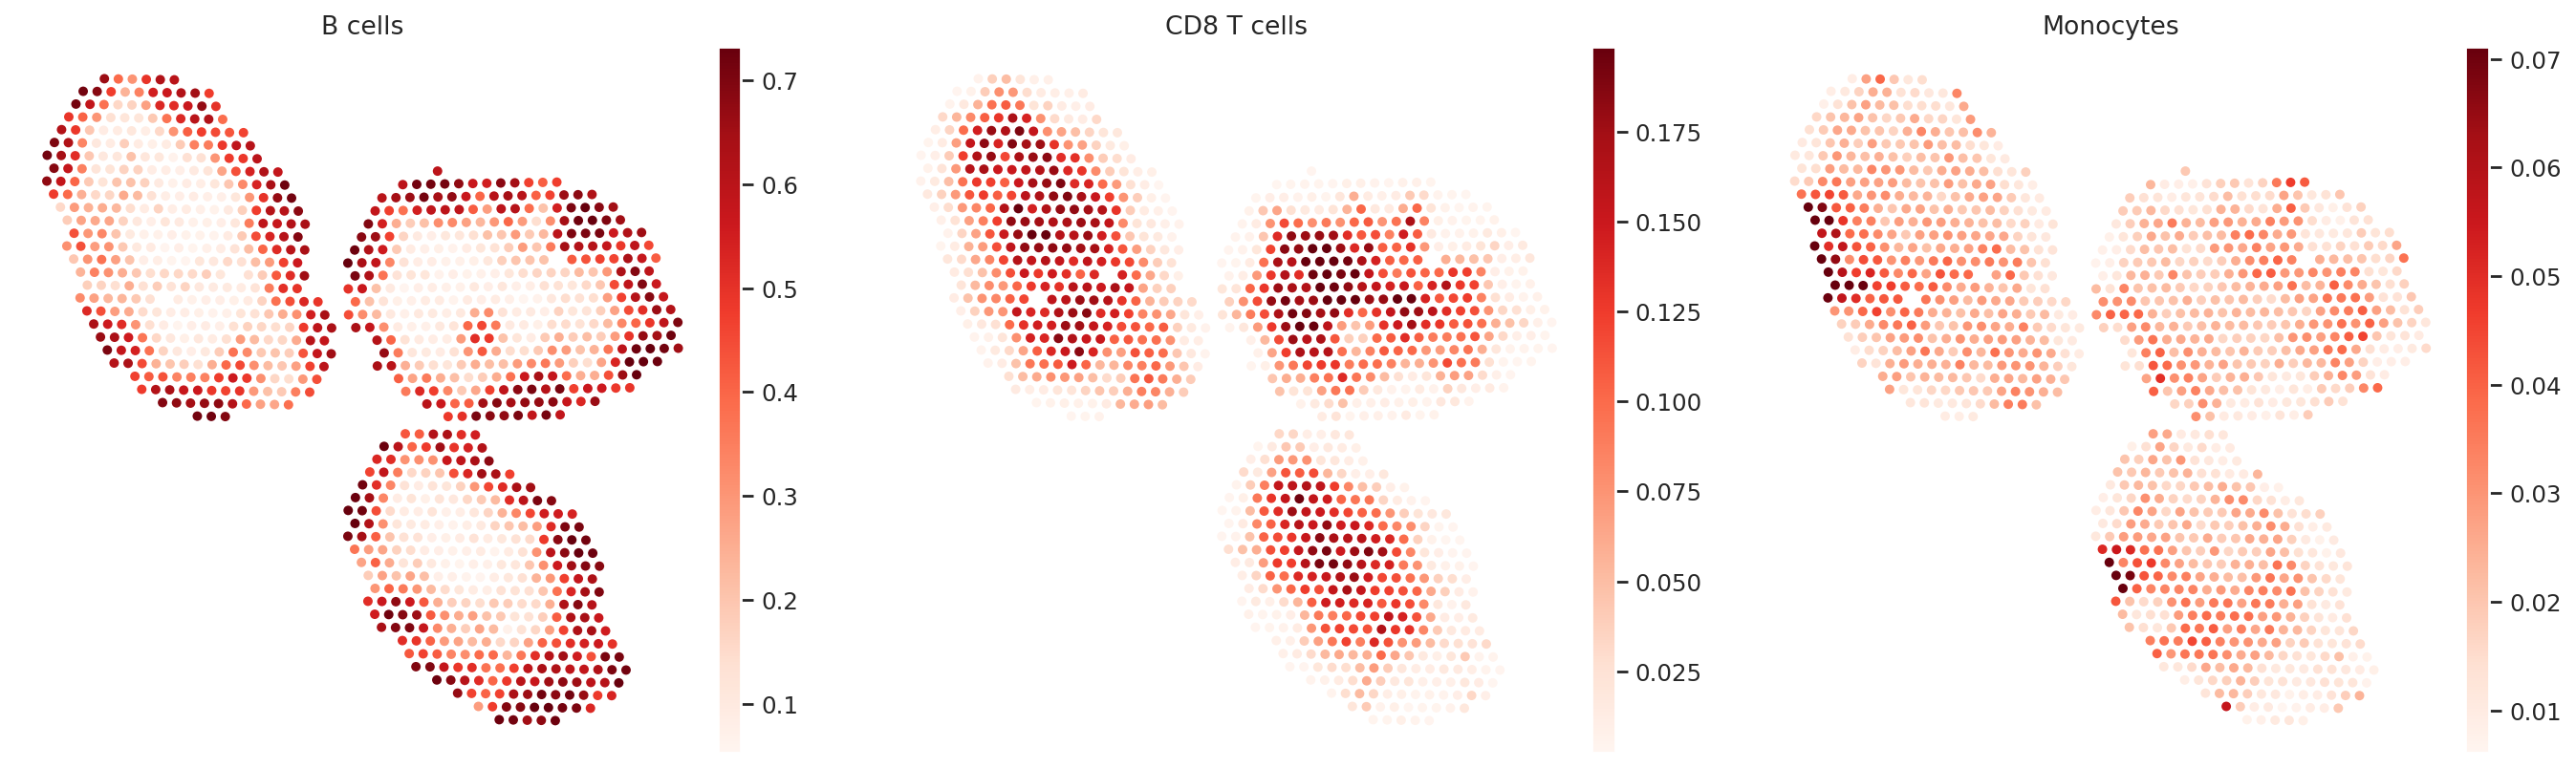

In [23]:
sc.pl.embedding(st_adata, basis="spatial", color=ct_list, cmap="Reds", s=80)

细胞内类型信息

In [24]:
# more globally, the values of the gamma are all summarized in this dictionary of data frames
for ct, g in st_model.get_gamma().items():
    st_adata.obsm[f"{ct}_gamma"] = g

In [29]:
# len(st_adata.obsm["B cells_gamma"])
# st_adata.obsm["B cells_gamma"].columns
st_adata.obsm["B cells_gamma"].shape

(1092, 5)

In [ ]:
st_adata.obsm["B cells_gamma"].head(5)

,0,1,2,3,4
AAACCGGGTAGGTACC-1-0,-0.555524,0.131141,0.150046,-0.274882,0.594412
AAACCTCATGAAGTTG-1-0,-1.309952,-1.037888,0.392673,-0.838580,0.308356
AAAGACTGGGCGCTTT-1-0,-1.766793,-0.617519,0.381506,-0.564547,-0.223396
AAAGGGCAGCTTGAAT-1-0,-0.498066,-0.012978,0.292812,0.239748,-0.496341
AAAGTCGACCCTCAGT-1-0,0.160855,0.087786,0.046619,-0.982064,0.692606


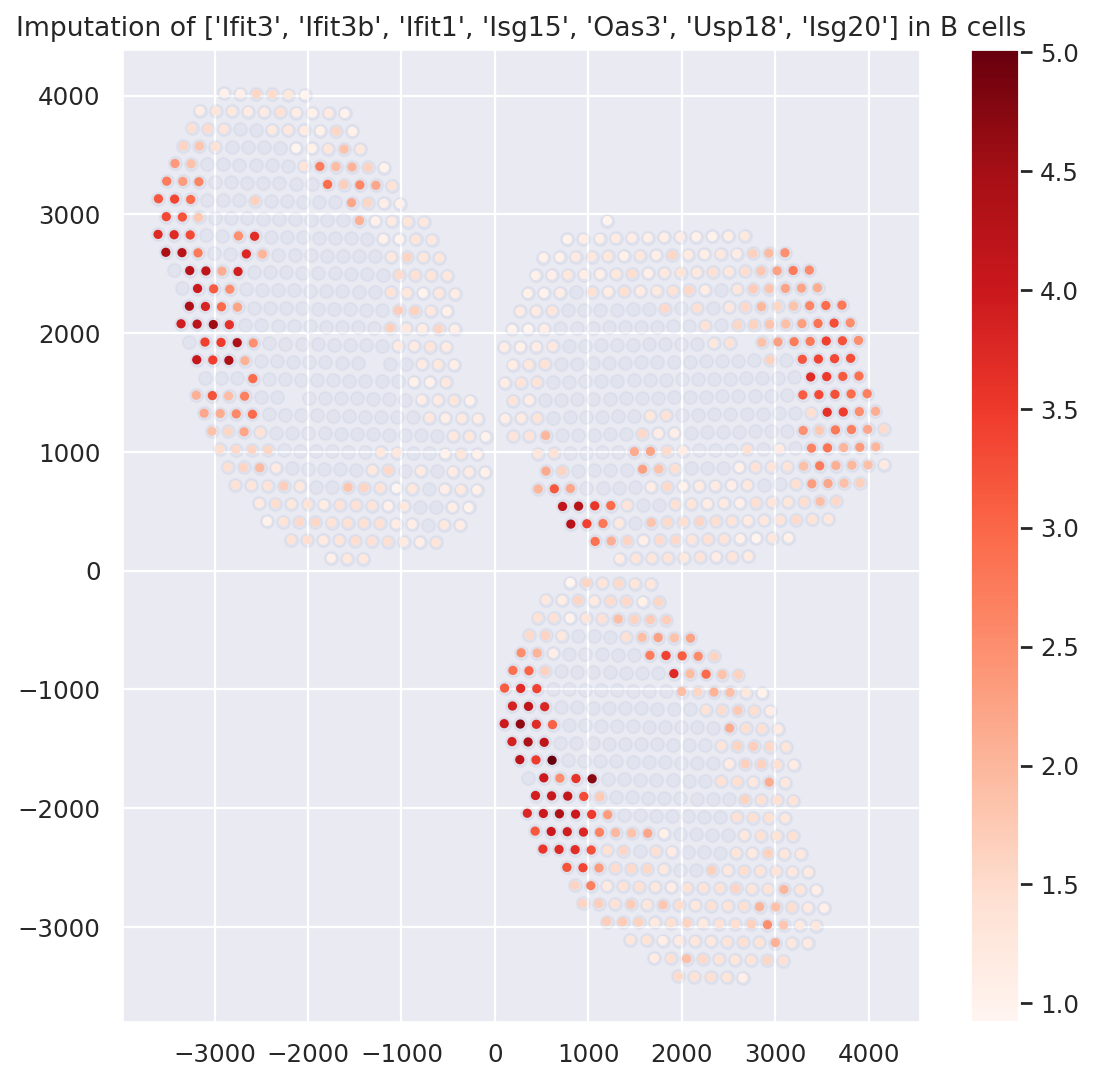

In [26]:
plt.figure(figsize=(8, 8))

ct_name = "B cells"
gene_name = ["Ifit3", "Ifit3b", "Ifit1", "Isg15", "Oas3", "Usp18", "Isg20"]

# we must filter spots with low abundance (consult the paper for an automatic procedure)
indices = np.where(st_adata.obsm["proportions"][ct_name].values > 0.2)[0]

# impute genes and combine them
specific_expression = np.sum(st_model.get_scale_for_ct(ct_name, indices=indices)[gene_name], 1)
specific_expression = np.log(1 + 1e4 * specific_expression)

# plot (i) background (ii) g
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(
    st_adata.obsm["location"][indices][:, 0],
    st_adata.obsm["location"][indices][:, 1],
    c=specific_expression,
    s=10,
    cmap="Reds",
)
plt.colorbar()
plt.title(f"Imputation of {gene_name} in {ct_name}")
plt.show()

为了测试git修好没，我又又写了这句

其实把ssh改成https就能解决问题

注释+重启了